# Transfer Learning With Poutyne

In [1]:
%pip install --upgrade poutyne # to install lastest poutyne version, if it's not already
import os
import tarfile
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment

ERROR: Invalid requirement: '#'


Note: you may need to restart the kernel to use updated packages.


Also, we need to set Pythons's, NumPy's and PyTorch's seeds by using Poutyne function so that our training is (almost) reproducible.

In [2]:
set_seeds(42)

We download the dataset.

In [3]:
def download_and_extract_dataset(path):
    os.makedirs(path, exist_ok=True)
    tgz_filename = os.path.join(path, "images.tgz")

    print("Downloading dataset...")
    urllib.request.urlretrieve("https://graal.ift.ulaval.ca/public/CUB200.tgz", tgz_filename)
    print("Extracting archive...")
    archive = tarfile.open(tgz_filename)
    archive.extractall(path)

In [4]:
base_path = './datasets/CUB200'
extract_dest = os.path.join(base_path, 'images')
download_and_extract_dataset(base_path)

Extracting archive...


We create our dataset object.

In [5]:
norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962, 0.4914721, 0.42382449), (0.22846779, 0.22387765, 0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(*norm_coefs['cub200']),
    ]
)

# is_valid_file removes hidden files from the dataset.
dataset = ImageFolder(
    extract_dest,
    transform=transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

We do the split train/valid/test with a 60/20/20 split respectively. We do a *stratified* split with scikit-learn in order to get examples of every class in every split.

In [6]:
# We take 60% of the dataset for the training dataset
train_indices, valid_test_indices = train_test_split(
    np.arange(len(dataset)),
    train_size=0.6,
    stratify=dataset.targets,
    random_state=42,
)
# We take 20% for the validation dataset and 20% for the test dataset
# (i.e. 50% of the remaining 40%).
valid_indices, test_indices = train_test_split(
    valid_test_indices,
    train_size=0.5,
    stratify=np.asarray(dataset.targets)[valid_test_indices],
    random_state=42,
)

train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)
test_dataset = Subset(dataset, test_indices)

Now, let's set our training constants. We first have the CUDA device used for training if one is present. Secondly, we set the number of classes (i.e. one for each number). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).


In [7]:
# Training constants
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 200
batch_size = 64
learning_rate = 0.1
n_epoch = 30

Creation of the PyTorch's dataloader to split our data into batches.

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

We load a pretrained `ResNet-18` networks and replace the head with the number of neurons equal to our number of classes.

In [9]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

We freeze the network except for its head.

In [10]:
def freeze_weights(resnet18):
    for name, param in resnet18.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False


freeze_weights(resnet18)

We define callbacks for saving last epoch, best epoch and logging the results.

In [11]:
# We are saving everything into ./saves/cub200.
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'cub200')
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

Finally, we start the training and output its final test loss, accuracy, and micro F1-score.

> Note that the F1-score is quite similar to the accuracy since the dataset is very balanced.

In [12]:
optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

model = Model(
    resnet18,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    callbacks=callbacks,
)

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch:  1/30 Train steps: 57 Val steps: 19 39.34s loss: 4.978818 acc: 5.029014 fscore_macro: 0.039684 val_loss: 4.404608 val_acc: 6.379453 val_fscore_macro: 0.049241
Epoch 1: val_acc improved from -inf to 6.37945, saving file to saves\cub200\best_epoch_1.ckpt
Epoch:  2/30 Train steps: 57 Val steps: 19 36.71s loss: 3.720372 acc: 24.758221 fscore_macro: 0.215321 val_loss: 3.635850 val_acc: 21.375311 val_fscore_macro: 0.161545
Epoch 2: val_acc improved from 6.37945 to 21.37531, saving file to saves\cub200\best_epoch_2.ckpt
Epoch:  3/30 Train steps: 57 Val steps: 19 38.39s loss: 2.918761 acc: 42.525560 fscore_macro: 0.389796 val_loss: 3.176135 val_acc: 30.240265 val_fscore_macro: 0.269019
Epoch 3: val_acc improved from 21.37531 to 30.24027, saving file to saves\cub200\best_epoch_3.ckpt
Epoch:  4/30 Train steps: 57 Val steps: 19 40.08s loss: 2.358893 acc: 55.346781 fscore_macro: 0.533795 val_loss: 2.925254 val_acc: 33.802817 val_fscore_macro: 0.308913
Epoch 4: val_acc improved from 30.24027

Epoch: 25/30 Train steps: 57 Val steps: 19 52.69s loss: 0.378220 acc: 98.784195 fscore_macro: 0.988155 val_loss: 2.049805 val_acc: 49.627175 val_fscore_macro: 0.484028
Epoch: 26/30 Train steps: 57 Val steps: 19 49.33s loss: 0.370279 acc: 98.922354 fscore_macro: 0.989537 val_loss: 2.045434 val_acc: 49.130075 val_fscore_macro: 0.475853
Epoch: 27/30 Train steps: 57 Val steps: 19 44.66s loss: 0.350627 acc: 99.253938 fscore_macro: 0.992965 val_loss: 2.041180 val_acc: 50.704225 val_fscore_macro: 0.494226
Epoch 27: val_acc improved from 49.71002 to 50.70423, saving file to saves\cub200\best_epoch_27.ckpt
Epoch: 28/30 Train steps: 57 Val steps: 19 45.18s loss: 0.332832 acc: 99.226306 fscore_macro: 0.992411 val_loss: 2.043334 val_acc: 49.212925 val_fscore_macro: 0.476270
Epoch: 29/30 Train steps: 57 Val steps: 19 43.86s loss: 0.323238 acc: 99.336833 fscore_macro: 0.993683 val_loss: 2.052169 val_acc: 50.538525 val_fscore_macro: 0.491494
Epoch: 30/30 Train steps: 57 Val steps: 19 45.48s loss: 0.3

In [13]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch       time   lr      loss        acc  fscore_macro  val_loss  \
0       1  39.336709  0.1  4.978818   5.029014      0.039684  4.404608   
1       2  36.709232  0.1  3.720372  24.758221      0.215321  3.635850   
2       3  38.385235  0.1  2.918761  42.525560      0.389796  3.176135   
3       4  40.082928  0.1  2.358893  55.346781      0.533795  2.925254   
4       5  38.620391  0.1  1.968704  64.714009      0.635180  2.685543   
5       6  39.559011  0.1  1.696290  71.096988      0.706240  2.528417   
6       7  40.929801  0.1  1.467466  76.153634      0.757667  2.482652   
7       8  39.569835  0.1  1.295805  79.497099      0.794096  2.383095   
8       9  40.190013  0.1  1.155749  82.426085      0.824142  2.321824   
9      10  41.282698  0.1  1.030440  86.432716      0.865001  2.262991   
10     11  57.474735  0.1  0.936738  88.366952      0.884028  2.256287   
11     12  79.203603  0.1  0.857720  89.555126      0.895726  2.204251   
12     13  49.404491  0.1  0.789653  9

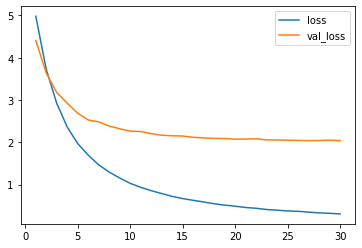

In [14]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

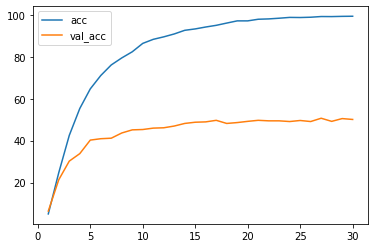

In [15]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

Since we have created checkpoints using callbacks, we can restore the best model from those checkpoints and test it.

In [16]:
resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)

model = Model(
    resnet18,
    'sgd',
    'cross_entropy',
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.load_weights(os.path.join(save_path, 'best_epoch_{epoch}.ckpt').format(epoch=best_epoch))

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Test steps: 19 15.35s test_loss: 2.004838 test_acc: 51.284176 test_fscore_macro: 0.510672            


We can also use the Experiment class to train our network. This class saves checkpoints and logs as above in a directory and allows to stop and resume optimization at will. See documentation for details.

In [17]:
def experiment_train(epochs):
    # Reload the pretrained network and freeze it except for its head.
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    freeze_weights(resnet18)

    # Saves everything into ./saves/cub200_resnet18_experiment
    save_path = os.path.join(save_base_dir, 'cub200_resnet18_experiment')

    optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)

    # Poutyne Experiment
    exp = Experiment(
        save_path,
        resnet18,
        device=device,
        optimizer=optimizer,
        task='classif',
    )

    # Train
    exp.train(train_loader, valid_loader, epochs=epochs)

    # Test
    exp.test(test_loader)

Let’s train for 5 epochs.

In [18]:
experiment_train(epochs=5)

Epoch: 1/5 Train steps: 57 Val steps: 19 36.63s loss: 4.970873 acc: 5.167173 fscore_macro: 0.037896 val_loss: 4.425690 val_acc: 8.119304 val_fscore_macro: 0.056513
Epoch 1: val_acc improved from -inf to 8.11930, saving file to saves\cub200_resnet18_experiment\checkpoint_epoch_1.ckpt
Epoch: 2/5 Train steps: 57 Val steps: 19 39.85s loss: 3.717953 acc: 24.868748 fscore_macro: 0.218832 val_loss: 3.649325 val_acc: 22.535211 val_fscore_macro: 0.187761
Epoch 2: val_acc improved from 8.11930 to 22.53521, saving file to saves\cub200_resnet18_experiment\checkpoint_epoch_2.ckpt
Epoch: 3/5 Train steps: 57 Val steps: 19 42.89s loss: 2.908639 acc: 44.072948 fscore_macro: 0.412258 val_loss: 3.239816 val_acc: 28.748964 val_fscore_macro: 0.256008
Epoch 3: val_acc improved from 22.53521 to 28.74896, saving file to saves\cub200_resnet18_experiment\checkpoint_epoch_3.ckpt
Epoch: 4/5 Train steps: 57 Val steps: 19 45.61s loss: 2.367300 acc: 55.263885 fscore_macro: 0.529713 val_loss: 2.910698 val_acc: 34.962

Let’s train for 5 more epochs (10 epochs total).

In [19]:
# Retrain for 5 more epochs
experiment_train(epochs=10)

Loading weights from saves\cub200_resnet18_experiment\checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from saves\cub200_resnet18_experiment\checkpoint.optim and starting at epoch 6.
Epoch:  6/10 Train steps: 57 Val steps: 19 38.34s loss: 1.682145 acc: 72.285162 fscore_macro: 0.714644 val_loss: 2.619942 val_acc: 38.856669 val_fscore_macro: 0.364058
Epoch 6: val_acc improved from 36.53687 to 38.85667, saving file to saves\cub200_resnet18_experiment\checkpoint_epoch_6.ckpt
Epoch:  7/10 Train steps: 57 Val steps: 19 40.24s loss: 1.451036 acc: 76.181266 fscore_macro: 0.759764 val_loss: 2.480303 val_acc: 42.419221 val_fscore_macro: 0.395808
Epoch 7: val_acc improved from 38.85667 to 42.41922, saving file to saves\cub200_resnet18_experiment\checkpoint_epoch_7.ckpt
Epoch:  8/10 Train steps: 57 Val steps: 19 43.93s loss: 1.285407 acc: 80.105001 fscore_macro: 0.800183 val_loss: 2.417424 val_acc: 44.324772 val_fscore_macro: 0.416435
Epoch 8: val_acc improved from 42.41922 to 44.3